# Measuring the Gender Pay Gap with Blinder-Oaxaca Decompositions
###### (And comparing to existing measures)
---------
#### Christopher Fong and Ronald Walker

SUMMARY: A gender pay gap exists when one gender, either male or female, earn higher wages. A gender pay gap can then be measured in two ways -- either adjusted or unadjusted. The unadjusted gap is just the difference in average earned wages. The adjusted gap is the pay gap that remains when other factors, such as hours worked and roles taken on are accounted for. The adjusted gap attempts to measure if males and females get the same wage for the same work.

We attempt to take a look at the components of the gender pay gap for multiple countries, implementing a commonly used method for the problem.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
import seaborn as sns
import numpy as np
plt.style.use('ggplot')
%matplotlib inline

**Table of Contents:**
1. Implementation and Interpretation of Blinder-Oaxaca

2. Data Collection and Cleaning

3. Application and Comparison

## 1. Implementation and Interpretation of Blinder-Oaxaca

Blinder-Oaxaca decompositions are easily performed in Stata with the `oaxaca` package. There is also an R package, but there is yet to be one created for Python. This project is the underlying foundation for a Python implementation.

The goal of a Blinder-Oaxaca decomposition is to take the difference in expected outcomes between two groups, and identify what contributes to the outcome gap. 

### Decompositions

*Note: Because the scope of this project is to create a greater understanding of the root of potential pay gaps, this walkthrough will be in the context of that. Our outcome of interest will be wages $w$. The two groups we will be comparing are males $m$ and females $f$.*

In this section we'll break down the calculation of the decomposition. The gap in wages is the difference between the average wage for males and the average wage for females.

$$Gap = E[Wage_m] - E[Wage_f]$$

We substitute $Wage$ for each group with a linear model of the following form, where $X$ are the attributes that determine an individual's wage, and $\epsilon$ is an error term:

$$Wage= X'\beta + \epsilon$$

with $\bar\epsilon=0$. After plugging the linear models for each gender into the $Gap$ equation, and using the assumptions that the expectation of the errors is zero and $E[\beta]=\beta$, we are left with

$$Gap = E[X_m]'\beta_m - E[X_f]'\beta_f$$

We can further decompose the regression terms and $X$ values to identify the source of the difference. There are two main ways that Oaxaca-type decompositions are broken down.

#### 1. Three-fold

The first decomposition breaks down into three parts:

$$Gap = (E[X_m]-E[X_f])'\beta_f \quad \quad (1)$$
$$+E[X_f]'(\beta_m-\beta_f) \quad \quad \quad (2)$$
$$+(E[X_m]-E[X_f])'(\beta_m-\beta_f) \quad \quad (3)$$

Each of these represents a source of the difference, we'll call them the Endowment (1), Coefficient (2), and Interaction (3) terms.

(1) The first term is the portion of the gap that comes from different **endowments**, that is, the difference in attributes between males and females. So a difference in educational attainment would be captured here.

(2) The second term is the portion of the gap difference that comes from different **coefficients**, or the difference in returns from their attributes. So a difference in the value that education returns to wages would be captured here.

(3) The third term is the portion of the gap that comes from the **interaction** between the different endowments and coefficients.

In summary, a difference in the slope for education is in (2), and being somewhere else along that line is in (1).

-------
*It is important to note that this decomposition uses the female regression as its baseline. In (1), we use the female regression coefficients to calculate the different endowment effect, and in (2), we use the female values of $E[X]$ to calculate the impact of different coefficients. This can easily be done using a male regression baseline by switching the order of the terms.*

If we want to see the contributions to each of (1), (2), and (3) from individual variables (each row in $X$), we are able to use the fact that each is a summation of the contributions from each subfactor. Using the Endowment term as an example, for each of the $m$ variables:

$$(E[X_m]-E[X_f])'\beta_f = \sum_{i=1}^{m}(E[X_{mi}]-E[X_{fi}])'\beta_{fi}$$

We can pull out a term of the summation for variable analysis.

------

#### 2. Two-fold

A second type of Blinder-Oaxaca type decomposition is a two-fold decomposition. It splits the gap into two components: an explained portion $E$ and an unexplained portion $U$.

$$Gap = E + U$$

This decomposition makes the assumption that there is a set of true regression coefficients, $\beta^*.$ There are many ways to calculate the true regression line, but it is highly contextual. If it is thought that there exists discrimination that is negative towards one group, and not positive towards the other, $\beta^*$ may just be the coefficients of the undiscriminated group. If one group benefits and the other is hurt by discrimination, $\beta^*$ is often calculated from a pooled regression between the two groups. We will be using a pooled regression as our $\beta^*$, though there are many other ways to calculate it.

The **explained** portion $E$ is called the "quantity effect", and is similar to the **endowments** term from the three-fold decomposition.

$$E = (E[X_m]-E[X_f])\beta^* $$

The **unexplained** portion $U$ captures the differences in coefficients from the true regression.

$$U = E[X_m](\beta_m-\beta^*) + E[X_f](\beta^*-\beta_f) $$

This **unexplained** portion is normally attributed to discrimination, but as stated in the Jann paper, "this interpretation hinges on the assumption that there are no relevant unobserved predictors."(4) If we have low explanatory power in our regression equations, there is potential for most of the noise to be captured in this term.

Even though discrimination is normally attributed to the coefficients, sometimes there is discrimination that presents itself in the endowment terms. For example, if females are less likely to be admitted to school because of discrimination, then they will have lower education values not naturally inherent to them.

*Note: we will include an indicator for gender in our pooled model (this is what Stata does in their implementation).*

#### Summary:

Three-fold: difference in endowments, difference in returns to those endowments, and interaction between those endowments and the rate of return. Uses one of the groups as a baseline. Discrimination is measured from differences in returns and (sometimes) from the interaction term.

Two-fold: difference in endowments and difference in returns from endowments. We use a pooled baseline. Discrimination is measured from the unexplained term (the difference in returns from endowments).

### Implementation

Below, we walk through the steps that it takes to perform a single Blinder-Oaxaca decomposition.

#### Reading Data

We use data from Canada to perform this operation.

In [2]:
df = pd.read_csv('data/Canada.csv').drop(['COUNTRY', 'PERWT'], axis=1)
# inserting a constant term
df['constant'] = 1
# making an indicator for gender
df['female'] = (df['SEX'] == 'Female').astype(float)
df.drop('SEX', axis=1, inplace=True)
print(df.shape)
df.head()

(724237, 10)


,AGE,MARST,NATIVITY,EDATTAIN,EMPSTAT,OCCISCO,INDGEN,INCTOT,constant,female
0,72,Widowed,Native-born,Less than primary completed,Inactive,NIU (not in universe),NIU (not in universe),9.961756,1,0.0
1,32,Single/never married,Native-born,Secondary completed,Employed,Crafts and related trades workers,Other services,10.694215,1,0.0
2,40,Married/in union,Native-born,Secondary completed,Employed,Clerks,Public administration and defense,10.956056,1,0.0
3,37,Married/in union,Native-born,Secondary completed,Employed,Technicians and associate professionals,Wholesale and retail trade,10.515967,1,1.0
4,51,Married/in union,Native-born,Secondary completed,Employed,Technicians and associate professionals,"Transportation, storage and communications",10.138560,1,1.0


We transform our categorical variables into dummy variables for our later regressions.

In [3]:
# adding dummy variables for categorical vars, and dropping the first one to remove colinearity
dummies = pd.get_dummies(df[['MARST', 'NATIVITY', 'EDATTAIN', 'EMPSTAT', 'OCCISCO', 'INDGEN']], drop_first=True)
df = pd.concat([df[['INCTOT']], dummies, df[['female', 'AGE', 'constant']]], axis=1)

We need to split our data into two sets, one for females and one for males.

In [4]:
male = df[df['female']==0].reset_index(drop=True).drop('female', axis=1)
female = df[df['female']==1].reset_index(drop=True).drop('female', axis=1)

Xm = male.drop('INCTOT', axis=1)
Xf = female.drop('INCTOT', axis=1)
Ym = male['INCTOT']
Yf = female['INCTOT']

We then use that to make two regression models, using `statsmodels`'s OLS.

In [5]:
female_model = sm.OLS(Yf, Xf).fit()
male_model = sm.OLS(Ym, Xm).fit()

From these models, we are able to access $X_f$, $X_m$, $\beta_f$, and $\beta_m$, which are necessary to solve our equations. 

In [6]:
Bf = female_model.params
Bm = male_model.params

### Decomposition

Our goal is to attribute the gap between two groups to certain differences. The wage gap between males and females is defined as 

$$Gap = E[Wage_m] - E[Wage_f]$$

The gap is computed below (remember that we are dealing with log wages).

In [7]:
male_mean = np.mean(Ym)
female_mean = np.mean(Yf)

gap = male_mean - female_mean
gap

0.3037566274879566

#### Three-fold Decomposition

The three-fold decomposition is split into three parts, Endowments, Coefficients, and Interactions.

$$Gap = Endowments + Coefficients + Interactions$$

Those are calculated individually below.

$$Endowments = (E[X_m]-E[X_f])'\beta_f$$

In [8]:
endowments = np.transpose(np.mean(Xm) - np.mean(Xf)) @ np.array(Bf)
endowments

0.075722997634111083

$$Coefficients = E[X_f]'(\beta_m-\beta_f)$$

In [9]:
coefficients = np.transpose(np.mean(Xf)) @ np.array(Bm - Bf)
coefficients

0.22345359683362187

$$Interactions = (E[X_m]-E[X_f])'(\beta_m-\beta_f)$$

In [10]:
interaction = np.transpose(np.mean(Xm) - np.mean(Xf)) @ np.array(Bm - Bf)
interaction

0.0045800330209516734

We are able to individually solve for the contribution from the coefficients. We calculate the contribution that comes from each variable for endowments in the cell below.

In [11]:
# variable contributions to endowments
(np.mean(Xm) - np.mean(Xf)) * Bf

MARST_Separated/divorced/spouse absent               -0.002493
MARST_Single/never married                           -0.011740
MARST_Widowed                                        -0.019391
NATIVITY_Native-born                                  0.001543
NATIVITY_Unknown/missing                              0.000001
EDATTAIN_Secondary completed                          0.003757
EDATTAIN_University completed                        -0.010440
EMPSTAT_Inactive                                      0.047626
EMPSTAT_Unemployed                                   -0.005272
OCCISCO_Crafts and related trades workers             0.018959
OCCISCO_Elementary occupations                       -0.005013
OCCISCO_Legislators, senior officials and managers    0.023513
OCCISCO_NIU (not in universe)                         0.006788
OCCISCO_Plant and machine operators and assemblers   -0.004656
OCCISCO_Professionals                                -0.009733
OCCISCO_Service workers and shop and market sales     0

#### Two-fold Decomposition

$$Gap = Explained + Unexplained$$

First we have to calculate our pooled model, from which we will get our $\beta^*$.

In [12]:
pooled_model = sm.OLS(df['INCTOT'], df.drop('INCTOT', axis=1)).fit()
B_star = pooled_model.params.drop('female')

$$E = (E[X_m]-E[X_f])\beta^* $$

In [13]:
explained = np.transpose(np.mean(Xm) - np.mean(Xf)) @ np.array(B_star)
explained

0.078886205651931746

$$U = E[X_m]'(\beta_m-\beta^*) + E[X_f]'(\beta^*-\beta_f) $$

In [14]:
unexplained = np.transpose(np.mean(Xm)) @ np.array(Bm-B_star) + np.transpose(np.mean(Xf)) @ np.array(B_star-Bf)
unexplained

0.2248704218367529

### Summary Tables

In our package, we use the `statsmodels` implementation of `SimpleTable` to build our summary tables. We compare our results to Stata's outputs using the same data.

First displayed is the three-fold decomposition, followed by the two-fold.

In [15]:
mydata = [[male_mean], [female_mean], [gap], [endowments], [coefficients], [interaction]]
myheaders = ["Coef."]#, "Std. Err.", "z"]
mystubs = ["group_1", "group_2", "difference", "endowments", "coefficients", "interaction"]
tbl = SimpleTable(mydata, myheaders, mystubs, title="Blinder-Oaxaca Decomposition: Three-Fold")
tbl

,Coef.
group_1,10.234547702209856
group_2,9.930791074721899
difference,0.3037566274879566
endowments,0.0757229976341
coefficients,0.223453596834
interaction,0.00458003302095


![](images/three-fold.png)

In [16]:
mydata = [[male_mean], [female_mean], [gap], [explained], [unexplained]]
myheaders = ["Coef."]#, "Std. Err.", "z"]
mystubs = ["group_1", "group_2", "difference", "explained", "unexplained"]
tbl = SimpleTable(mydata, myheaders, mystubs, title="Blinder-Oaxaca Decomposition: Pooled")
tbl

,Coef.
group_1,10.234547702209856
group_2,9.930791074721899
difference,0.3037566274879566
explained,0.0788862056519
unexplained,0.224870421837


![](images/pooled.png)

Below is an example of splitting up the components of the coefficients term from the three-fold decomposition.

In [17]:
cfs = np.mean(Xf) * (male_model.params - female_model.params)
mydata = [[co] for co in cfs]
myheaders = [ "Coef."]#, "Std. Err.", "z"
mystubs = list(cfs.index)
tbl = SimpleTable(mydata, myheaders, mystubs, title="Blinder-Oaxaca Decomposition - $C$")
tbl

,Coef.
MARST_Separated/divorced/spouse absent,-0.0271724652886
MARST_Single/never married,-0.0585922945188
MARST_Widowed,-0.0235621121724
NATIVITY_Native-born,0.101755124514
NATIVITY_Unknown/missing,-1.44134985957e-06
EDATTAIN_Secondary completed,0.031518105719
EDATTAIN_University completed,0.00781105200052
EMPSTAT_Inactive,0.017192818169
EMPSTAT_Unemployed,-0.00269069173622
OCCISCO_Crafts and related trades workers,0.000563035836238


### Implementation Addendum

We are building on top of `statsmodels`, so the framework will easily translate to regression models outside of just OLS, including weighted least squares and [logistic models](http://www.econ.yale.edu/growth_pdf/cdp873.pdf). We are currently working on adding the package to the Python Package Index and thus making it pip installable. Like in Stata, there are a couple of different options of output available, including detailed models and varying standard error estimation methods. 

## 2. Data

Census data was extracted from IPUMS for Brazil, Canada, Panama, Puerto Rico, and the United States.  Canada's data is from 2011 while the rest are from 2010.  Each observation represents a person who was surveyed.  Cleaning was performed using R and imported using the **ipumsr** package.  

The following variables were selected from IPUMS: Person Weight, Age, Sex, Marital Status, Nativity, Educational Attainment, Employment Status, Occupation, Industry, and Total Income.  Only person's aged 16 and older were selected.  Total Income for Brazil and Panama was scaled by 12 to account for reporting differences (monthly vs yearly).  Total Income has also been log transformed and filtered to include only those with incomes greater than 0.  

The goal for our analysis is to use Blinder-Oaxaca decomposition on different countries' gender income gaps to calculate the explained and unexplained differentials and compare these proportions with published measures of gender inequality. To accompish this, we will regress Total Income on gender and other demographic variables. We use the value of SEX to split the data into our two groups.

In [18]:
Brazil = pd.read_csv('data/Brazil.csv')
Canada = pd.read_csv('data/Canada.csv')
Panama = pd.read_csv('data/Panama.csv')
PuertoRico = pd.read_csv('data/PuertoRico.csv')
UnitedStates = pd.read_csv('data/UnitedStates.csv')
Brazil.head()

,COUNTRY,PERWT,AGE,SEX,MARST,NATIVITY,EDATTAIN,EMPSTAT,OCCISCO,INDGEN,INCTOT
0,Brazil,18.54,22,Male,Married/in union,Native-born,Primary completed,Employed,Crafts and related trades workers,Manufacturing,9.392662
1,Brazil,20.23,54,Male,Married/in union,Native-born,Less than primary completed,Employed,Service workers and shop and market sales,Real estate and business services,9.035987
2,Brazil,20.23,44,Female,Married/in union,Native-born,Less than primary completed,Employed,Elementary occupations,Private household services,8.522778
3,Brazil,20.23,22,Female,Single/never married,Native-born,Less than primary completed,Inactive,NIU (not in universe),NIU (not in universe),8.719317
4,Brazil,20.23,26,Female,Single/never married,Native-born,Secondary completed,Employed,Technicians and associate professionals,Health and social work,8.961879


In [19]:
countries = [Brazil, Canada, Panama, PuertoRico, UnitedStates]
countryNames = ["Brazil", "Canada", "Panama", "PuertoRico", "UnitedStates"]

Below we plot histograms of age for each of our countries. Brazil and Panama appear to have younger populations since their ages are skewed right.  Canada, Puerto Rico, and the United States are more centered around age 50-60.  There don't appear to be any drastic differences in age for males and females in each country, though women tend to live slightly longer.  Older people would be expected to earn more because they have more experience.  Although our Age variable doesn't fully reflect a person's experience, the fact that there aren't gender age inequalities is helpful for understanding our analysis. 

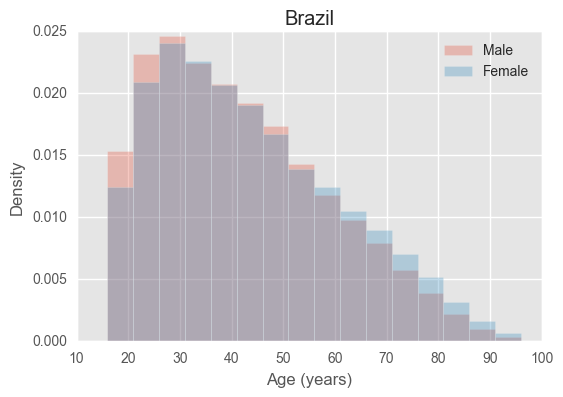

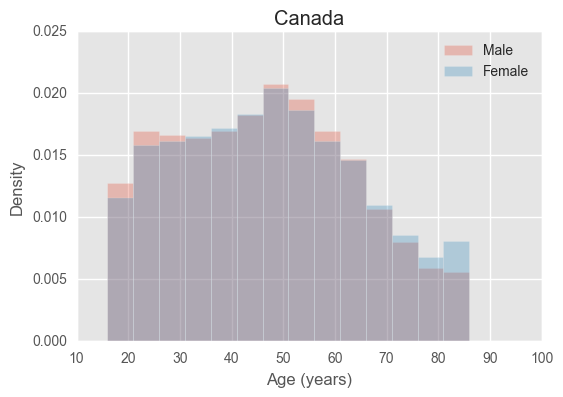

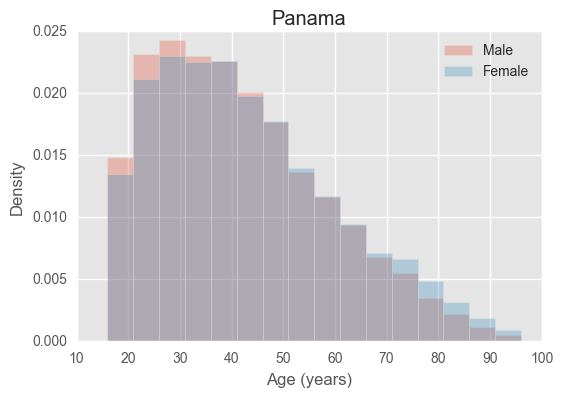

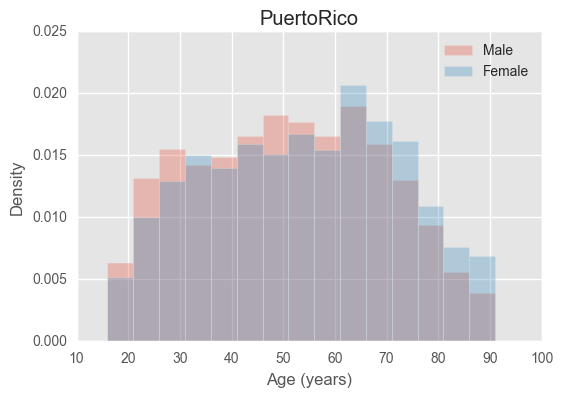

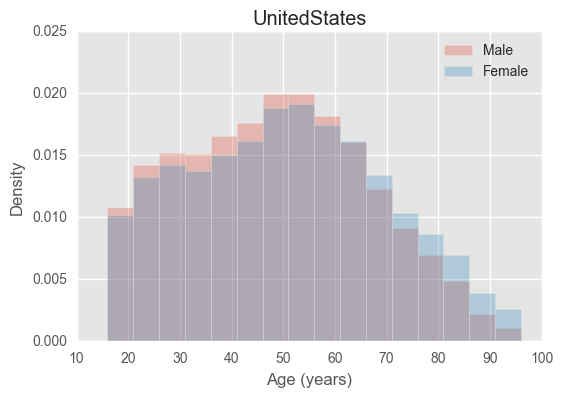

In [20]:
bins = np.arange(16, 100, 5)
for i in range(0, 5):
    plt.figure(i)
    plt.hist(data=countries[i][countries[i]["SEX"] == "Male"], x="AGE", normed=True, alpha=0.3, label="Male", bins=bins)
    plt.hist(data=countries[i][countries[i]["SEX"] == "Female"], x="AGE", normed=True, alpha=0.3, label="Female", bins=bins)
    plt.title(countryNames[i])
    plt.xlabel('Age (years)')
    plt.ylabel('Density')
    plt.ylim(0, .025)
    plt.legend()

Each country's INCTOT variable was reported in the currency of that country.  Looking at the histograms below, Male and Female incomes are generally centered around the same values, though for all of our countries, men seem to be slightly shifted right, with the greatest difference coming from Panama. If we think that there is no discrimination, and the difference in wages is just from preferences, we would expect this should be reflected in the difference in industry choice in our regression model.

Given that these currency values are local and not transformed to a standard value, the different shifts along the x-axis do not mean much to us. This doesn't matter though, because we are only making intra-country comparisons.

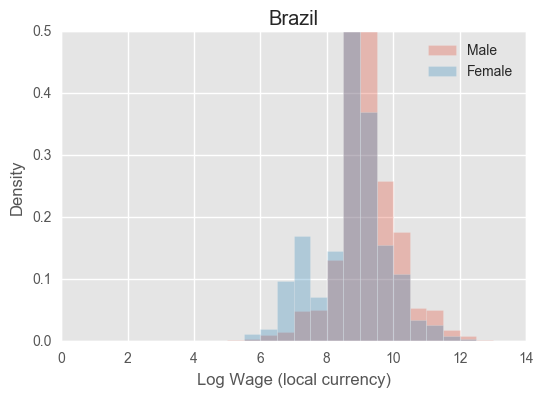

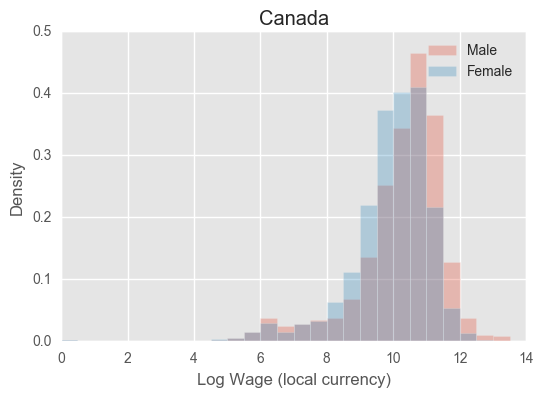

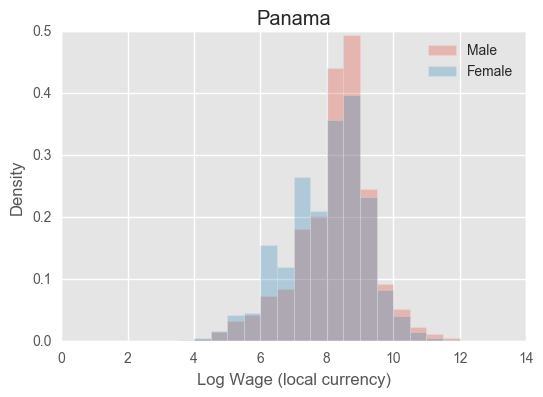

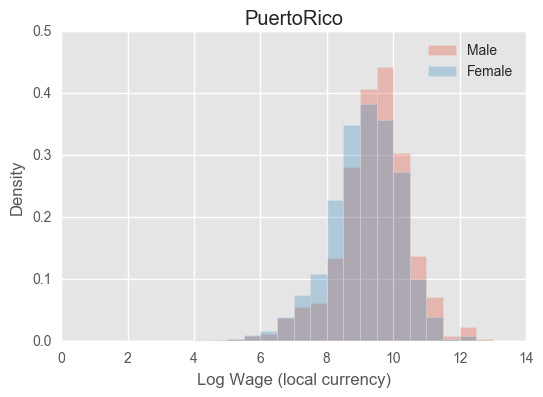

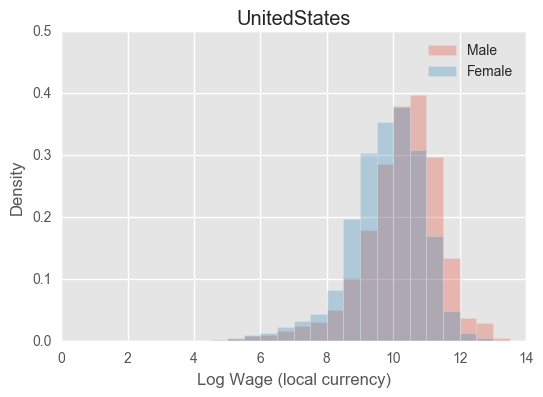

In [21]:
bins = np.arange(0,14,.5)
for i in range(0, 5):
    plt.figure(i)
    plt.hist(data=countries[i][countries[i]["SEX"] == "Male"], x="INCTOT", normed=True, alpha=0.3, label="Male", bins=bins)
    plt.hist(data=countries[i][countries[i]["SEX"] == "Female"], x="INCTOT", normed=True, alpha=0.3, label="Female", bins=bins)
    plt.title(countryNames[i])
    plt.ylim(0, .5)
    plt.xlabel('Log Wage (local currency)')
    plt.ylabel('Density')
    plt.legend()

Next, this big block of code is used to perform some crosstabulations for different categorical variables.

In [22]:
ctab1 = {}
for i in range(0, 5):
    ctab1[countryNames[i]]= pd.crosstab(
        index=countries[i]['EDATTAIN'],
        columns=countries[i]['SEX'],
        values=countries[i]['INCTOT'],
        aggfunc=np.mean
    ).round(2)
    ctab1[countryNames[i]]["Difference"] = ctab1[countryNames[i]]["Male"] - ctab1[countryNames[i]]["Female"]
    
ctab2 = {}
for i in range(0, 5):
    ctab2[countryNames[i]]= pd.crosstab(
        index=countries[i]['EDATTAIN'],
        columns=countries[i]['SEX'],
        values=countries[i]['INCTOT'],
        aggfunc=np.size
    ).apply(lambda x: x/np.sum(x)).round(2)
    ctab2[countryNames[i]]["Difference"] = ctab2[countryNames[i]]["Male"] - ctab2[countryNames[i]]["Female"]

ctab3 = {}
for i in range(0, 5):
    ctab3[countryNames[i]]= pd.crosstab(
        index=countries[i]['INDGEN'],
        columns=countries[i]['SEX'],
        values=countries[i]['INCTOT'],
        aggfunc=np.mean
    ).round(2)
    ctab3[countryNames[i]]["Difference"] = ctab3[countryNames[i]]["Male"] - ctab3[countryNames[i]]["Female"]
    ctab3[countryNames[i]] = ctab3[countryNames[i]].sort_values("Difference", ascending=False)
    
ctab4 = {}
for i in range(0, 5):
    ctab4[countryNames[i]]= pd.crosstab(
        index=countries[i]['INDGEN'],
        columns=countries[i]['SEX'],
        values=countries[i]['INCTOT'],
        aggfunc=np.size
    ).apply(lambda x: x/np.sum(x)).round(2)
    ctab4[countryNames[i]]["Difference"] = ctab4[countryNames[i]]["Male"] - ctab4[countryNames[i]]["Female"]
    ctab4[countryNames[i]] = ctab4[countryNames[i]].reindex(ctab3[countryNames[i]].index)

Across each country, we can see that average total income increases with education level.  Among education levels, males tend to have higher incomes.  

In [23]:
for i in range(0, 5):
    display(countryNames[i], ctab1[countryNames[i]].reindex(ctab1[countryNames[i]].Difference.abs().sort_values(ascending=False).index))

'Brazil'

SEX,Female,Male,Difference
EDATTAIN,,,
Primary completed,8.47,9.07,0.60
University completed,9.94,10.46,0.52
Secondary completed,8.97,9.46,0.49
Less than primary completed,8.46,8.86,0.40


'Canada'

SEX,Female,Male,Difference
EDATTAIN,,,
Secondary completed,9.86,10.19,0.33
University completed,10.34,10.65,0.31
Less than primary completed,9.46,9.73,0.27


'Panama'

SEX,Female,Male,Difference
EDATTAIN,,,
Less than primary completed,7.20,7.89,0.69
Primary completed,7.75,8.32,0.57
University completed,9.27,9.62,0.35
Secondary completed,8.55,8.82,0.27
Unknown,10.80,10.88,0.08


'PuertoRico'

SEX,Female,Male,Difference
EDATTAIN,,,
Primary completed,8.49,8.93,0.44
Secondary completed,9.04,9.38,0.34
University completed,9.93,10.25,0.32
Less than primary completed,8.54,8.77,0.23


'UnitedStates'

SEX,Female,Male,Difference
EDATTAIN,,,
University completed,10.38,10.92,0.54
Secondary completed,9.64,10.07,0.43
Less than primary completed,9.16,9.56,0.40
Primary completed,8.93,9.30,0.37


This is interesting because when looking at the percentage of each gender at each education level, women complete University at similar or greater rates than men.

In [24]:
for i in range(0, 5):
    display(countryNames[i], ctab2[countryNames[i]].reindex(ctab2[countryNames[i]].Difference.abs().sort_values(ascending=False).index))

'Brazil'

SEX,Female,Male,Difference
EDATTAIN,,,
Primary completed,0.23,0.28,0.05
University completed,0.11,0.07,-0.04
Secondary completed,0.25,0.24,-0.01
Less than primary completed,0.41,0.41,0.00


'Canada'

SEX,Female,Male,Difference
EDATTAIN,,,
University completed,0.28,0.26,-0.02
Secondary completed,0.55,0.57,0.02
Less than primary completed,0.17,0.17,0.00


'Panama'

SEX,Female,Male,Difference
EDATTAIN,,,
Primary completed,0.32,0.44,0.12
University completed,0.23,0.12,-0.11
Secondary completed,0.33,0.29,-0.04
Less than primary completed,0.12,0.14,0.02
Unknown,0.00,0.00,0.00


'PuertoRico'

SEX,Female,Male,Difference
EDATTAIN,,,
University completed,0.28,0.19,-0.09
Secondary completed,0.46,0.52,0.06
Primary completed,0.15,0.18,0.03
Less than primary completed,0.12,0.11,-0.01


'UnitedStates'

SEX,Female,Male,Difference
EDATTAIN,,,
Secondary completed,0.61,0.59,-0.02
Primary completed,0.09,0.11,0.02
University completed,0.27,0.28,0.01
Less than primary completed,0.02,0.02,0.00


Across industries, Males tend to earn more than Females.  The tables have been sorted by the difference in Male and Female incomes.

In [25]:
for i in range(0, 5):
    display(countryNames[i], ctab3[countryNames[i]].reindex(ctab3[countryNames[i]].Difference.abs().sort_values(ascending=False).index))

'Brazil'

SEX,Female,Male,Difference
INDGEN,,,
"Other industry, n.e.c.",10.53,9.76,-0.77
NIU (not in universe),8.35,8.96,0.61
"Agriculture, fishing, and forestry",8.32,8.71,0.39
Manufacturing,8.97,9.35,0.38
Financial services and insurance,9.70,10.07,0.37
Health and social work,9.45,9.82,0.37
"Electricity, gas and water",8.92,9.29,0.37
Response suppressed,9.39,9.71,0.32
Other services,8.94,9.25,0.31


'Canada'

SEX,Female,Male,Difference
INDGEN,,,
Wholesale and retail trade,9.84,10.19,0.35
Mining,10.74,11.06,0.32
"Agriculture, fishing, and forestry",9.77,10.08,0.31
Manufacturing,10.27,10.57,0.30
Health and social work,10.35,10.65,0.30
Financial services and insurance,10.59,10.89,0.30
Other services,9.92,10.20,0.28
NIU (not in universe),9.40,9.65,0.25
Real estate and business services,10.22,10.45,0.23


'Panama'

SEX,Female,Male,Difference
INDGEN,,,
NIU (not in universe),7.57,8.19,0.62
"Other industry, n.e.c.",9.39,9.97,0.58
Construction,9.24,8.70,-0.54
Manufacturing,8.21,8.69,0.48
Unknown,9.49,9.94,0.45
Health and social work,8.95,9.34,0.39
Hotels and restaurants,8.30,8.56,0.26
Private household services,7.78,7.98,0.20
Financial services and insurance,9.31,9.50,0.19


'PuertoRico'

SEX,Female,Male,Difference
INDGEN,,,
Private household services,8.44,9.17,0.73
Wholesale and retail trade,9.20,9.57,0.37
NIU (not in universe),8.69,9.05,0.36
Health and social work,9.62,9.94,0.32
Financial services and insurance,9.98,10.26,0.28
Hotels and restaurants,8.83,9.09,0.26
Construction,9.43,9.19,-0.24
"Electricity, gas and water",10.45,10.27,-0.18
Manufacturing,9.59,9.77,0.18


'UnitedStates'

SEX,Female,Male,Difference
INDGEN,,,
Financial services and insurance,10.39,11.04,0.65
"Agriculture, fishing, and forestry",9.34,9.92,0.58
Health and social work,10.07,10.63,0.56
Wholesale and retail trade,9.55,10.07,0.52
NIU (not in universe),9.37,9.82,0.45
Real estate and business services,10.07,10.48,0.41
Manufacturing,10.12,10.52,0.40
Other services,9.49,9.88,0.39
Public administration and defense,10.39,10.70,0.31


The tables below show the percentage of Males and Females in each industry.  The industries are ordered by industry income difference (shown in the tables above).

In [26]:
for i in range(0, 5):
    display(countryNames[i], ctab4[countryNames[i]].reindex(ctab4[countryNames[i]].Difference.abs().sort_values(ascending=False).index))

'Brazil'

SEX,Female,Male,Difference
INDGEN,,,
NIU (not in universe),0.35,0.15,-0.20
"Agriculture, fishing, and forestry",0.08,0.19,0.11
Construction,0.00,0.10,0.10
Private household services,0.10,0.01,-0.09
Education,0.07,0.02,-0.05
"Transportation, storage and communications",0.01,0.06,0.05
Manufacturing,0.07,0.11,0.04
Wholesale and retail trade,0.10,0.13,0.03
Unknown,0.03,0.05,0.02


'Canada'

SEX,Female,Male,Difference
INDGEN,,,
Health and social work,0.13,0.03,-0.10
NIU (not in universe),0.31,0.22,-0.09
Construction,0.01,0.09,0.08
Manufacturing,0.04,0.10,0.06
Education,0.07,0.04,-0.03
"Transportation, storage and communications",0.02,0.05,0.03
Real estate and business services,0.08,0.11,0.03
Mining,0.00,0.02,0.02
Hotels and restaurants,0.05,0.04,-0.01


'Panama'

SEX,Female,Male,Difference
INDGEN,,,
NIU (not in universe),0.33,0.13,-0.20
"Agriculture, fishing, and forestry",0.01,0.16,0.15
Construction,0.01,0.14,0.13
Private household services,0.09,0.01,-0.08
"Transportation, storage and communications",0.04,0.10,0.06
Education,0.08,0.03,-0.05
Manufacturing,0.03,0.07,0.04
Health and social work,0.05,0.02,-0.03
Hotels and restaurants,0.04,0.02,-0.02


'PuertoRico'

SEX,Female,Male,Difference
INDGEN,,,
NIU (not in universe),0.46,0.34,-0.12
Construction,0.00,0.08,0.08
Education,0.11,0.04,-0.07
Health and social work,0.09,0.03,-0.06
Manufacturing,0.04,0.07,0.03
Other services,0.02,0.05,0.03
Real estate and business services,0.06,0.09,0.03
"Transportation, storage and communications",0.01,0.04,0.03
Wholesale and retail trade,0.08,0.11,0.03


'UnitedStates'

SEX,Female,Male,Difference
INDGEN,,,
Health and social work,0.16,0.04,-0.12
Construction,0.01,0.09,0.08
NIU (not in universe),0.25,0.18,-0.07
Manufacturing,0.05,0.12,0.07
Education,0.11,0.05,-0.06
"Transportation, storage and communications",0.03,0.07,0.04
Real estate and business services,0.08,0.11,0.03
Wholesale and retail trade,0.10,0.12,0.02
Public administration and defense,0.04,0.05,0.01


## 3. Application

Below we are going to take a look at each of the Blinder-Oaxaca decompositions. First we read in the results of our decompositions. The first set include occupation and industry as controls, while `two_fold_no_industry` does not. We will bring up the importance of that shortly.

In [27]:
three_fold = pd.read_csv('results/three_fold.csv')
two_fold = pd.read_csv('results/two_fold.csv')

two_fold_no_industry = pd.read_csv('results/two_fold_no_industry.csv')

In [28]:
print('Three-Fold Decomposition Results')
display(three_fold)
print('Two-Fold Decomposition Results')
display(two_fold)

Three-Fold Decomposition Results


,Country,Group 1,Group 2,Gap,Endowments,Coefficients,Interaction
0,Canada,10.234548,9.930791,0.303757,0.075403,0.223892,0.005010
1,Panama,8.577076,8.300325,0.276751,-0.000339,0.346114,-0.069024
2,PuertoRico,9.396607,9.142558,0.254050,-0.031305,0.264629,0.020725
3,UnitedStates,10.214523,9.768357,0.446166,0.032713,0.352656,0.060606
4,Brazil,9.175472,8.753409,0.422063,0.098009,0.373664,-0.049650


Two-Fold Decomposition Results


,Country,Group 1,Group 2,Gap,Explained,Unexplained
0,Canada,10.234548,9.930791,0.303757,0.078782,0.225523
1,Panama,8.577076,8.300325,0.276751,-0.052990,0.329741
2,PuertoRico,9.396607,9.142558,0.254050,-0.044081,0.298131
3,UnitedStates,10.214523,9.768357,0.446166,0.050607,0.395368
4,Brazil,9.175472,8.753409,0.422063,0.054778,0.367221


In the following graph, we are make a comparison between the pay gaps in countries and the components that make them up from the decompositions. We start with the three-fold. If a bar is below zero, that means its value was negative, and that it works in favor of the females. So for example, for Puerto-Rico, we see that the endowments are below zero, which means that the women in that country have greater endowments than the men.

The sum of the components is the gray bar to the right.

For most of the countries, it appears that the majority of the gap is from the coefficients, meaning that the women are likely to have the same behaviors as the men, but get less returns from them.

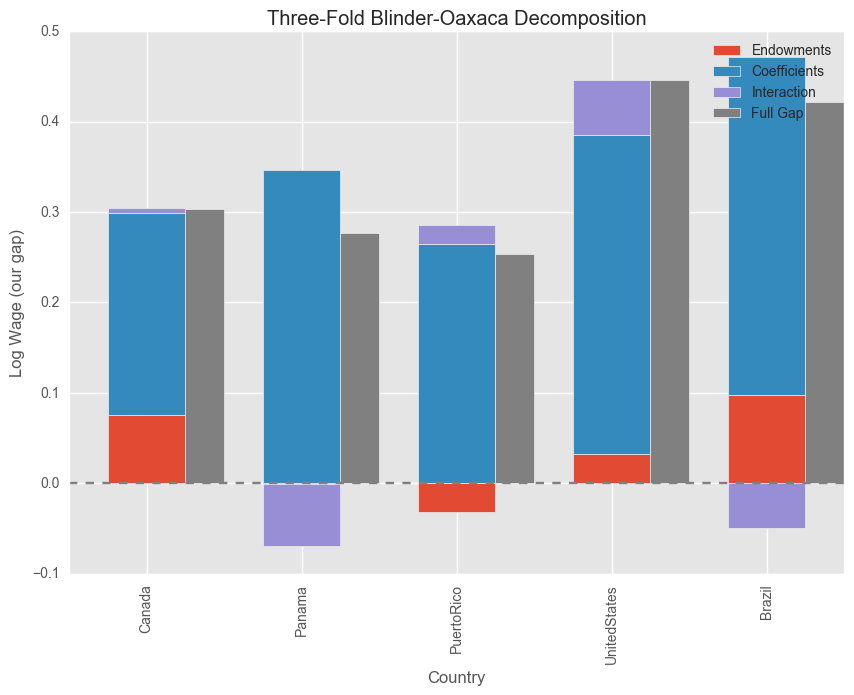

In [29]:
three_fold.index = three_fold['Country']
three_fold[['Endowments', 'Coefficients', 'Interaction']].plot.bar(stacked=True, figsize=(10,7))
plt.axhline(y=0, c='grey', linestyle='--')
plt.bar(plt.xticks()[0]+.25, three_fold['Gap'], width=.25, color='grey', label='Full Gap')
plt.ylabel('Log Wage (our gap)')
plt.legend()
plt.title('Three-Fold Blinder-Oaxaca Decomposition');

Below is the two-fold, which is the version commonly used in discrimination literature. We see that the unexplained portion is larger than the explained for all countries. We do need to keep in mind one of the key assumptions of this model -- that the unexplained can also capture the effects of having poor predictors (or not enough included, which is likely our case). So in our comparisons, it may be helpful to just include relative terms, that is, comparing the level of unexplained to other countries (which works because we have standardized explanatory variables).

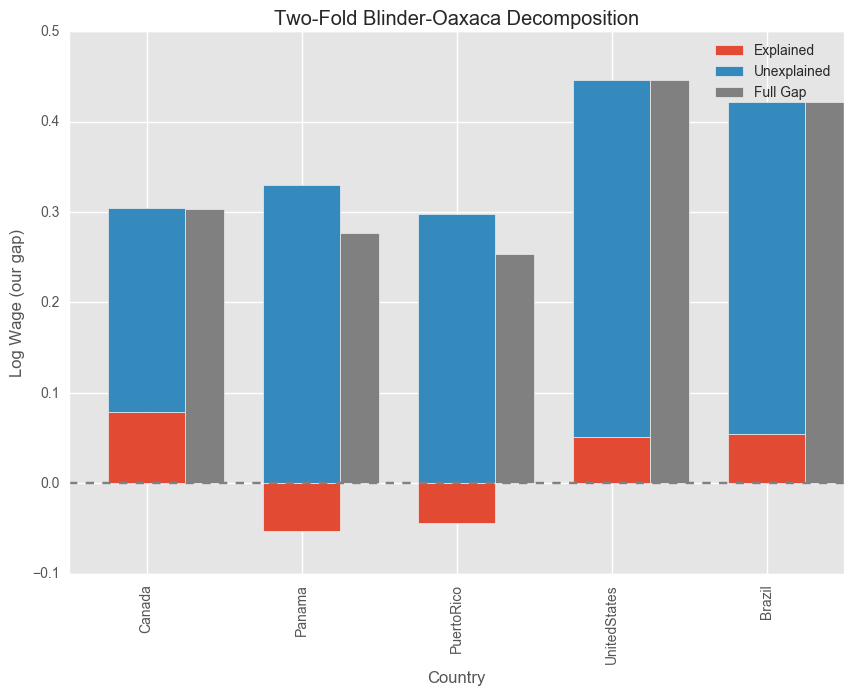

In [30]:
two_fold.index = two_fold['Country']
two_fold[['Explained', 'Unexplained']].plot.bar(stacked=True, figsize=(10,7))
plt.axhline(y=0, c='grey', linestyle='--')
plt.bar(plt.xticks()[0]+.25, two_fold['Gap'], width=.25, color='grey', label='Full Gap')
plt.ylabel('Log Wage (our gap)')
plt.legend()
plt.title('Two-Fold Blinder-Oaxaca Decomposition');

In this graph, we compare the unexplained  amount between the the two-fold decomposition where we do and don't include industry and occupation controls. It is commonly cited that including those controls overaccounts for instances of glass-ceilings and individuals being excluded from certain industries. So we would expect the actual level of discrimination to lie between the two values (the controlled and uncontrolled).

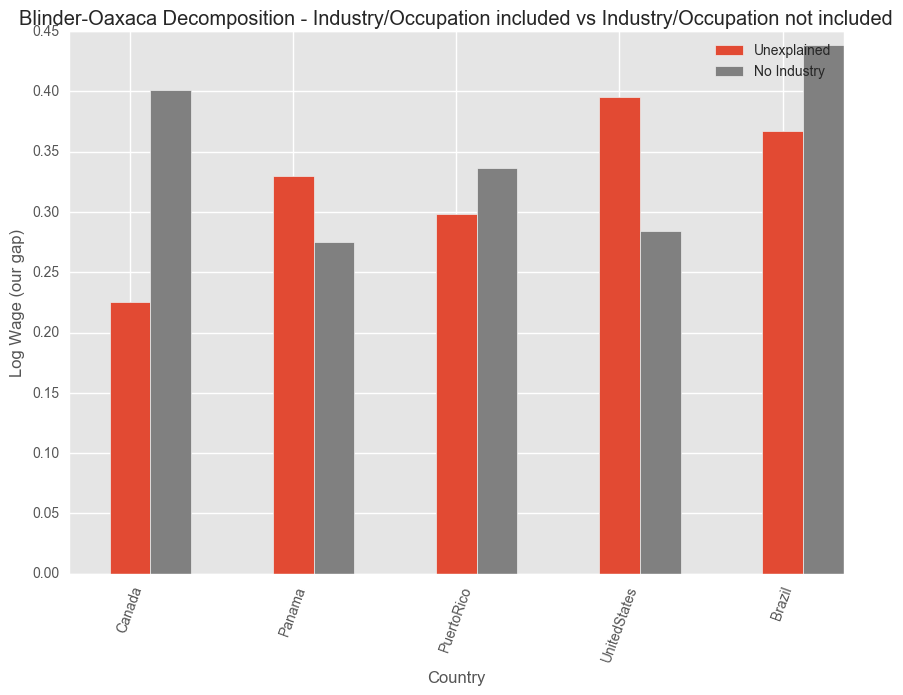

In [31]:
two_fold[['Unexplained']].plot.bar(figsize=(10,7), label='Including Industry', width=.25)
plt.bar(plt.xticks()[0]+.125, two_fold_no_industry['Unexplained'], width=.25, color='grey', label='No Industry')
plt.xticks(rotation=70)
plt.ylabel('Log Wage (our gap)')
plt.legend()
plt.title('Blinder-Oaxaca Decomposition - Industry/Occupation included vs Industry/Occupation not included');

In our final graph, we compare our unexplained value to the World Economic Forum's adjusted pay gap score. We take the relative proportion of the gap that is unexplained, and plot it on the x-axis against their index. You'll notice that there is a lot more variation in our value, but it is hard to make a good comparison when we only have four points (there was not score for Puerto Rico).

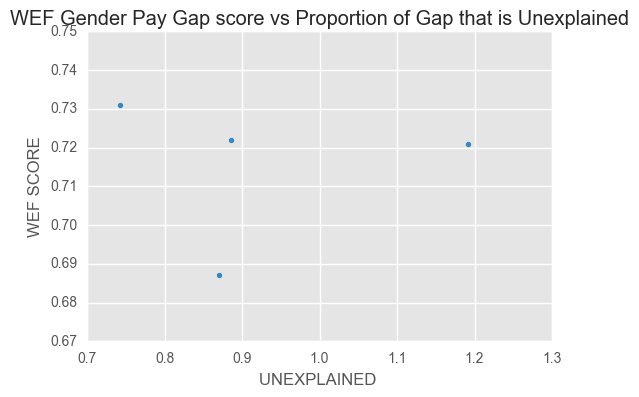

In [32]:
WEF_2016 = pd.read_csv("data/WEF.csv")[['Country', 'score']]
WEF_2016['Unexplained'] = list((two_fold['Unexplained']/two_fold['Gap']).drop('PuertoRico'))
WEF_2016.plot(kind='scatter', y='score', x='Unexplained')
plt.ylabel('WEF SCORE')
plt.xlabel('UNEXPLAINED ')
plt.title('WEF Gender Pay Gap score vs Proportion of Gap that is Unexplained');

It is helpful to look at the not only the gaps, but the relative importance of each of the factors (i.e. education) in the gaps would probably be more important in making policy decisions based on these types of decompositions. If we were to go forward further with the project, that would be our focus.

### Additional Caveats:  

* Person weights were not included in our analysis.  As a result, the samples aren't necessarily reflective of the populations from which they were drawn.  Future analysis could incorporate the weights.  
* Another problem our analysis suffers from is Omitted Variable Bias.  IPUMS is helpful because it tries to standardize variables across countries; however, this limmited the availability of variables we would have wished to include and control for in our regressions.  For example, we would have wanted to include a person's work experience and further broken down education levels.
* We make the assumption that discrimination lies mainly in unexplained, and doesn't spill over too much to endowments (for example, if women are denied access to school, that might be mainly captured in endowments, but that is cleary a discrimination issue).

# Group Contributions:  

Christopher worked on importing and cleaning the data from IPUMS.  He also created the visualizations and crosstabs.  Ronald created a package implementing Blinder-Oaxaca and wrote a description of the process.  He also ran the regressions using his package.  

Both partners contributed to the other aspects of the project including written analysis and descriptions.

**Citations:**

Jann, Ben, 2008. "<a href="https://EconPapers.repec.org/RePEc:ets:wpaper:5">A Stata implementation of the Blinder-Oaxaca decomposition</a>", No 5, ETH Zurich Sociology Working Papers, ETH Zurich, Chair of Sociology.

Kennedy, Peter & Jutta Heinrichs, 2007. "A Computational Trick for Calculating the Blinder-Oaxaca Decomposition and Its Standard Error," Economics Bulletin, AccessEcon, vol. 3(66), pages 1-7.  

Minnesota Population Center. Integrated Public Use Microdata Series, International: Version 7.0 [dataset]. Minneapolis, MN: IPUMS, 2018. http://doi.org/10.18128/D020.V7.0.